# Import para la maquina con Google Drive




In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import tensorflow as tf

print(os.getcwd())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/content
Num GPUs Available:  1


# Cargar y preprocesar datos


In [ ]:
# OPCION 1: Subir archivos al google drive, preferentemente subir la totalidad
# la carpeta a la caprte del drive raiz. Si no, modificar a la dirección escrita

from google.colab import drive
drive.mount('/content/drive')

option = 1

if option == 1:
  # OPCION 1: Subir archivos al google drive, preferentemente subir la totalidad
  # la carpeta a la caprte del drive raiz. Si no, modificar a la dirección escrita
  train_imgs = np.load('./drive/MyDrive/MIOCARDIO/train_imgs.npy')
  train_annot = np.load('./drive/MyDrive/MIOCARDIO/train_annot.npy')
  test_imgs = np.load('./drive/MyDrive/MIOCARDIO/test_imgs.npy')
  test_annot = np.load('./drive/MyDrive/MIOCARDIO/test_annot.npy')
  val_imgs = np.load('./drive/MyDrive/MIOCARDIO/val_imgs.npy')
  val_annot = np.load('./drive/MyDrive/MIOCARDIO/val_annot.npy')

else:
  # OPCION 2: Subir archivos al google colab, preferentemente subir la totalidad
  # la carpeta a la caprte del drive raiz. Si no, modificar a la dirección escrita
  train_imgs = np.load('./MIOCARDIO/train_imgs.npy')
  train_annot = np.load('./MIOCARDIO/train_annot.npy')
  test_imgs = np.load('./MIOCARDIO/test_imgs.npy')
  test_annot = np.load('./MIOCARDIO/test_annot.npy')
  val_imgs = np.load('./MIOCARDIO/val_imgs.npy')
  val_annot = np.load('./MIOCARDIO/val_annot.npy')

Mounted at /content/drive


In [ ]:
# Cambia el tipo de las imagenes a float
train_imgs = train_imgs.astype('float32')
train_annot = train_annot.astype('float32')
test_imgs = test_imgs.astype('float32')
test_annot = test_annot.astype('float32')
val_imgs = val_imgs.astype('float32')
val_annot = val_annot.astype('float32')

# Cambiamos los pixeles asociado a la clase 2 a que sean de clase 0
train_annot = np.where(train_annot[:][:][:]==2, 0, train_annot)
test_annot = np.where(test_annot[:][:][:]==2, 0, test_annot)
val_annot = np.where(val_annot[:][:][:]==2, 0, val_annot)

train_imgs = train_imgs / 255
test_imgs = test_imgs / 255
val_imgs = val_imgs / 255

train_imgs = tf.constant(np.expand_dims(train_imgs, axis=3))
train_annot = tf.constant(np.expand_dims(train_annot, axis=3))
test_imgs = tf.constant( np.expand_dims(test_imgs, axis=3))
test_annot = tf.constant(np.expand_dims(test_annot, axis=3))
val_imgs = tf.constant(np.expand_dims(val_imgs, axis=3))
val_annot = tf.constant(np.expand_dims(val_annot, axis=3))

# Plots para mostrar los datos y el sector esperado


In [ ]:
def display(display_list):
  '''
  Plotea graficos de la base de datos, mostrando la imagen de input con la 
  imagen que se espera conseguir.

  input : Un listado de matrices de 256x256

  '''
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
  plt.show()

def display_num(display_list, num):
  '''
  Plotea graficos de la base de datos, mostrando la imagen de input con la 
  imagen que se espera conseguir.

  input : Un listado de matrices de 256x256

  '''
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(f"Test numero: {num}")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
  plt.show()

# Creación del modelo


In [ ]:
# Codigo de funciones necesarias de coste
def iou(true_y, pred_y):
    """
    Funcion que retorna el valor de la metrica de Interseccion Over Union
    params:
    - true_y : matriz con los pixeles de la respuesta deseada
    - pred_y: matriz con los pixeles resultante del modelo

    return:
    - iou_value : valor de la metrica IoU
    """
    tp = tf.reduce_sum(pred_y * true_y)
    fp = tf.reduce_sum(tf.nn.relu(pred_y - true_y))
    fn = tf.reduce_sum(tf.nn.relu(true_y - pred_y))
    iou = tp / (tp + fp + fn)
    return iou

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
    
def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.9
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Modelo preliminar

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    """Funcion que retorna dos capas convolusionales continuas
      params:
      - input_tensor: capa inicial a unir
      - n_filters: numero de filtros a usar
      - kernerl_size: tamaño del kernel a usar

      return:
      - x: objeto de layers que representa la capa final del bloque de las dos 
        capas convolucionales
    """
    # first layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation="relu")(input_tensor)
    
    # second layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation="relu")(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1):
    """Funcnion para crear la Unet
    
      params:
      - input_images = tupla de 3 dimensiones con las dimensiones de la matriz
        entrada
      - n_filtros = numero de filtros iniciales
      - dropout = indice de dropout

      Return:
      - modelo: Un objeto Model de tensorflow con el modelo Unet creado
    """
    # encoder
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    if dropout > 0:
      p1 = tf.keras.layers.Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    if dropout > 0:
      p2 = tf.keras.layers.Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    if dropout > 0:
      p3 = tf.keras.layers.Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters = n_filters * 8, kernel_size = 3)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    if dropout > 0:
      p4 = tf.keras.layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3)
    
    # decoder
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = "same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    if dropout > 0:
      u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3)
    
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    if dropout > 0:
      u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3)
    
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    if dropout > 0:
      u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3)
    
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    if dropout > 0:
      u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

# Modelos siguientes a probar

In [ ]:
from keras import backend as K
def conv2d_block_batch(input_tensor, n_filters, kernel_size = 3):
    """Funcion que retorna un batch normalization y dos capas convolusionales continuas
      params:
      - input_tensor: capa inicial a unir
      - n_filters: numero de filtros a usar
      - kernerl_size: tamaño del kernel a usar

      return:
      - x: objeto de layers que representa la capa final del bloque de las dos 
        capas convolucionales
    """
    # batch layer
    x = tf.keras.layers.BatchNormalization()(input_tensor)

    # first layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation="relu")(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', activation="relu")(x) 
    
    return x

def get_unet_batch(input_img, n_filters = 16, dropout = 0.1, batch_activate = False):
    """Funcnion para crear la Unet
    
      params:
      - input_images = tupla de 3 dimensiones con las dimensiones de la matriz
        entrada
      - n_filtros = numero de filtros iniciales
      - dropout = indice de dropout

      Return:
      - modelo: Un objeto Model de tensorflow con el modelo Unet creado
    """
    #  Enconder
    c1 = conv2d_block_batch(input_img, n_filters * 1, kernel_size = 3)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    if dropout > 0:
        p1 = tf.keras.layers.Dropout(dropout)(p1)
    
    c2 = conv2d_block_batch(p1, n_filters * 2, kernel_size = 3)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    if dropout > 0:
        p2 = tf.keras.layers.Dropout(dropout)(p2)
    
    c3 = conv2d_block_batch(p2, n_filters * 4, kernel_size = 3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    if dropout > 0:
        p3 = tf.keras.layers.Dropout(dropout)(p3)
    
    c4 = conv2d_block_batch(p3, n_filters = n_filters * 8, kernel_size = 3)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    if dropout > 0:
        p4 = tf.keras.layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block_batch(p4, n_filters = n_filters * 16, kernel_size = 3)
    
    #  Decoder
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = "same")(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    if dropout > 0:
        u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = conv2d_block_batch(u6, n_filters * 8, kernel_size = 3)
    
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    if dropout > 0:
        u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block_batch(u7, n_filters * 4, kernel_size = 3)
    
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    if dropout > 0:
        u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block_batch(u8, n_filters * 2, kernel_size = 3)
    
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    if dropout > 0:
        u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block_batch(u9, n_filters * 1, kernel_size = 3)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# Codigo para seleccion de modelo

# Creación de metricas
metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), iou, dsc, tf.keras.metrics.MeanIoU(num_classes=2)]

# Creación del modelo
inputs = tf.keras.layers.Input((256, 256, 1), name='imagen')

modelo  = 0
if modelo == 0: # modelo preliminar A (binary y dropout)
    model = get_unet(inputs, n_filters=16, dropout=0.2)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)
elif modelo == 1: # dice (Modelo B)
    model = get_unet_batch(inputs, n_filters=16, dropout=0, batch_activate = True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss, metrics=metrics)
elif modelo == 2: # Focal tvresky (Modelo C)
    model = get_unet_batch(inputs, n_filters=16, dropout=0, batch_activate = True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=focal_tversky, metrics=metrics)

# Callbacks
log_dir = "logs/fit2/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
train_plot = np.random.randint(len(train_imgs)-10)
def plot_callback(i):
  display([train_imgs[i], train_annot[i], model.predict(train_imgs[i:(i+1)])[0]])

class PlotCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    plot_callback(train_plot)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    tensorboard_callback,
]


# Información del modelo

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# Segmento de Entrenamiento

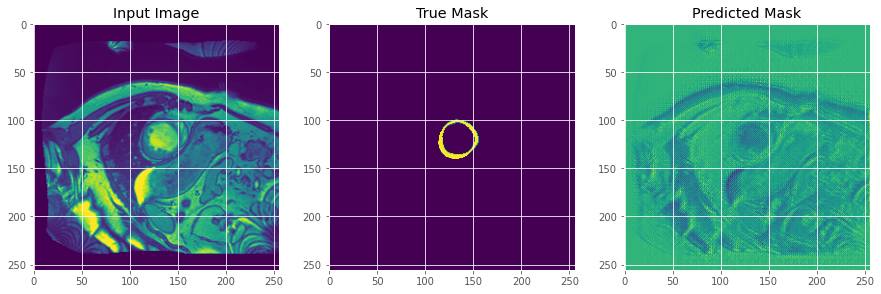

In [ ]:
predict = model.predict(test_imgs[10:11])
for i in range(1):
  display([test_imgs[10], test_annot[10], predict[i]])

In [ ]:
results = model.fit(train_imgs, train_annot, batch_size=32, epochs=15,\
                    validation_data=(val_imgs, val_annot), callbacks = callbacks, \
                    validation_batch_size=32)

# Segmento de validación y predicción

In [ ]:
predict = model.predict(test_imgs, callbacks = callbacks) 

In [ ]:
for i in range(20):
  num = np.random.randint(len(test_imgs)-20)
  print(f"dato numero: {num}")
  display_num([test_imgs[num], test_annot[num], predict[num]], num)

# Gráficos de metricas

In [ ]:
# Gráfico con los valores de loss en el entrenamiento
plt.figure(figsize=(10, 10))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Gráfico con los valores de accuracy en el entrenamiento
plt.figure(figsize=(10, 10))
plt.title("Accuracy curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();

In [ ]:
# Gráfico con los valores de presicion y recall en el entrenamiento
presicion = results.history["precision"]
presicion_val = results.history["val_precision"]
recall = results.history["recall"]
recall_val = results.history["val_recall"]


plt.figure(figsize=(10, 10))
plt.title("recall curve")
plt.plot(recall, label="recall")
plt.plot(recall_val , label="val_recall")
plt.xlabel("Epochs")
plt.ylabel("recall")
plt.legend();

print("\n")

plt.figure(figsize=(10, 10))
plt.title("presicion curve")
plt.plot(presicion, label="presicion")
plt.plot(presicion_val , label="val_presicion")
plt.xlabel("Epochs")
plt.ylabel("presicion")
plt.legend();

In [ ]:
# Gráfico con los valores de IoU en el entrenamiento
plt.figure(figsize=(10, 10))
plt.title("IoU curve")
plt.plot(results.history["iou"], label="iou")
plt.plot(results.history["val_iou"] , label="val_iou")
plt.xlabel("Epochs")
plt.ylabel("iou")
plt.legend();

In [ ]:
# Gráfico con los valores de IoU en el entrenamiento
plt.figure(figsize=(10, 10))
plt.title("meanIoU curve")
plt.plot(results.history["mean_io_u"], label="iou")
plt.plot(results.history["val_mean_io_u"] , label="val_iou")
plt.xlabel("Epochs")
plt.ylabel("mean_iou")
plt.legend();

In [ ]:
# Gráfico con los valores de dice en el entrenamiento
plt.figure(figsize=(10, 10))
plt.title("Dice curve")
plt.plot(results.history["dsc"], label="dice")
plt.plot(results.history["val_dsc"] , label="val_dice")
plt.xlabel("Epochs")
plt.ylabel("Dice")
plt.legend();

In [ ]:
# Histograma del modelo con el predict
pred_iou = []
for i in range(len(test_imgs)):
    pred_iou.append(iou(test_annot[i], predict[i]).numpy())
plt.figure(figsize=(10, 10))
plt.hist(pred_iou, facecolor='b', bins=30)
plt.xlabel('IoU')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

pred_iou = np.array(pred_iou)
mean = pred_iou.mean()
std = pred_iou.std()

print(f"Promedio : {mean}")
print(f"Desviación estandar : {std}")

# Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir logs/fit2/